# Simple FEM for one dimensional heat transfer problem

The problem for $T(t,x)$ is stated as
$$
\frac{\partial T}{\partial t} - \alpha \Delta T = 0 \quad \text{for} \quad x \in [0,L] , t \in [0, Z]
$$
with a constant heat conductivity $\alpha$ subject to the boundary condition
$$
T(t, x=0) = 1
$$
and the initial condition
$$
T(t=0, x) = \cos(2\pi x)
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import ufl
from dolfinx import fem, mesh, plot
from mpi4py import MPI
from petsc4py import PETSc

from global_constants import L, Z, alpha

# Mesh
N = 20
domain = mesh.create_interval(comm=MPI.COMM_WORLD, points=(0, L), nx=N)
facets = mesh.locate_entities_boundary(
    domain, dim=0, marker=lambda x: np.isclose(x[0], 0.0)
)
x = ufl.SpatialCoordinate(domain)

## Create the FEM basis

In [ ]:
# Function space
V = fem.FunctionSpace(domain, ("Lagrange", 1))

## Boundary condition and intial condition


In [ ]:
dofs = fem.locate_dofs_topological(V=V, entity_dim=0, entities=facets)
bc = fem.dirichletbc(PETSc.ScalarType(1), dofs=dofs, V=V)


# Initial condition
def initial_condition(x):
    return np.cos(2.0 * np.pi * x[0])


T_old = fem.Function(V)
T_old.name = "T_old"
T_old.interpolate(initial_condition)

## Problem formulation
Implicit time discretization yields 
$$
\frac{T^{n+1}-T^n}{\Delta t} = \alpha \Delta T^{n+1}
$$


The weak form of the equation to be solved is then

$$ 
 \int_\Omega T^{n+1} \cdot v dV  +  \Delta t \alpha \int_\Omega \nabla T^{n+1} \cdot \nabla v dV = \int_\Omega  T^{n} \cdot v dV
$$

In [ ]:
# Time step
dt = 1e-4

# Trial functions
T = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = T * v * ufl.dx + alpha * dt * ufl.inner(ufl.grad(T), ufl.grad(v)) * ufl.dx

t = 0
results = [T_old.x.array]
for i in range(1, int(Z / dt)):
    # Weak forms
    L = ufl.inner(T_old, v) * ufl.dx
    # Solve for T^n+1
    problem = fem.petsc.LinearProblem(
        a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
    )
    Th = problem.solve()
    # Save T_old
    T_old = Th
    # Save results for plotting
    if i % 100 == 0:
        results.append(Th.x.array)

## Visulization

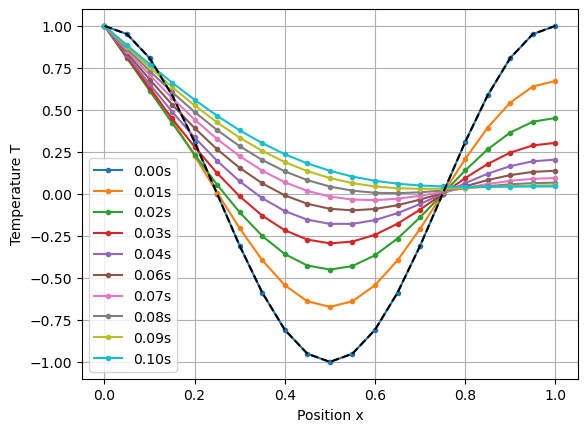

In [ ]:
cells, types, x = plot.create_vtk_mesh(V)
for res in results:
    plt.plot(x[:, 0], res, ".-")
plt.plot(x[:, 0], initial_condition(x.T), "--k")
plt.legend([f"{t:.2f}s" for t in np.linspace(0, Z, 10)])
plt.xlabel("Position x")
plt.ylabel("Temperature T")
plt.grid()